18:59:01 - cmdstanpy - INFO - Chain [1] start processing
18:59:14 - cmdstanpy - INFO - Chain [1] done processing


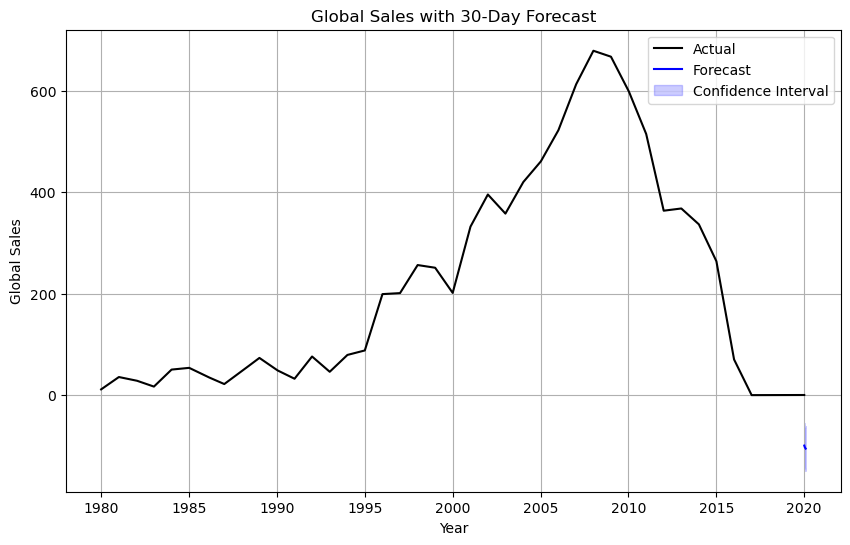

In [17]:
import pandas as pd
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.fbprophet import Prophet
import matplotlib.pyplot as plt
import numpy as np 

# Load and prepare the data
sales_data = pd.read_csv("sales.csv")
sales_data['Year'] = sales_data['Year'].fillna(0).astype(int)
sales_data = sales_data[sales_data['Year'] > 0]
sales_data['Year'] = pd.to_datetime(sales_data['Year'], format='%Y')

# Aggregate global sales by year and interpolate daily
sales_data = sales_data.groupby('Year')['Global_Sales'].sum()
sales_data = sales_data.resample('D').interpolate(method='linear')  # Interpolate missing daily data

# Define forecasting function
def plot_forecast_with_actual(dataset, horizon, forecaster):
    # Drop missing values and fit the model
    dataset = dataset.dropna()
    forecaster.fit(dataset)

    # Define forecast horizon
    last_date = dataset.index.max()
    fh = ForecastingHorizon(
        pd.date_range(last_date + pd.Timedelta(days=1), periods=horizon, freq='D'),
        is_relative=False,
    )

    # Generate predictions
    y_pred = forecaster.predict(fh)
    ci = forecaster.predict_interval(fh, coverage=0.9)  # Confidence intervals

    # Plot actual and forecast
    plt.figure(figsize=(10, 6))
    plt.plot(dataset, label="Actual", color="black")
    plt.plot(y_pred, label="Forecast", color="blue")
    plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color="blue", alpha=0.2, label="Confidence Interval")
    plt.title("Global Sales with 30-Day Forecast")
    plt.xlabel("Year")
    plt.ylabel("Global Sales")
    plt.legend()
    plt.grid()
    plt.show()

# Apply the Prophet model and forecast
forecaster = Prophet(yearly_seasonality=True, weekly_seasonality=False)
plot_forecast_with_actual(dataset=sales_data, horizon=30, forecaster=forecaster)


18:25:24 - cmdstanpy - INFO - Chain [1] start processing
18:25:42 - cmdstanpy - INFO - Chain [1] done processing


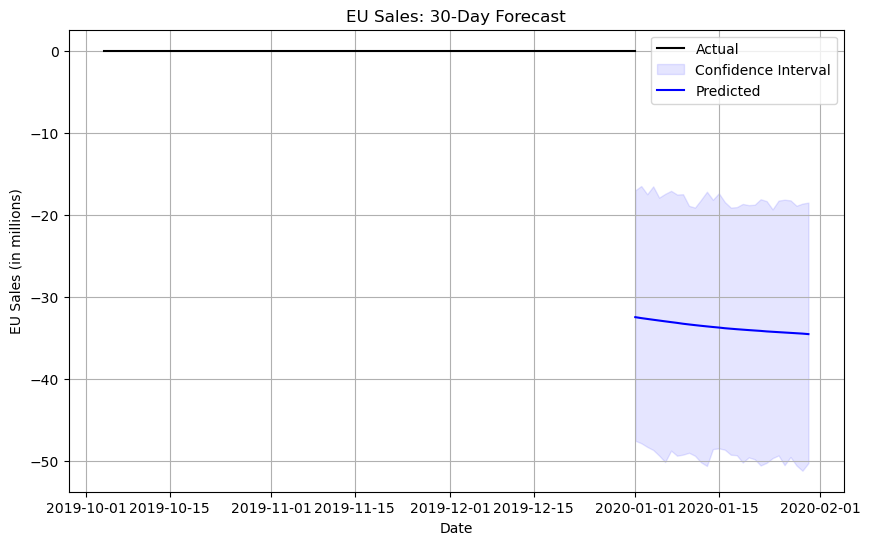

In [4]:
import pandas as pd
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.fbprophet import Prophet
import matplotlib.pyplot as plt

# Load and prepare the dataset
sales_data = pd.read_csv("sales.csv")
sales_data['Year'] = pd.to_datetime(sales_data['Year'], format='%Y', errors='coerce')
sales_data = sales_data.dropna(subset=['Year', 'EU_Sales'])  # Remove rows with missing Year or EU_Sales

# Aggregate EU_Sales by Year and resample to daily frequency
sales_data = sales_data.groupby('Year')['EU_Sales'].sum()
sales_data = sales_data.resample('D').interpolate(method='linear')  # Interpolate daily data

# Function to forecast using sktime
def sktime_forecast(dataset, horizon, forecaster, validation=False, confidence=0.9, frequency="D"):
    """Loop over a time series dataframe, train an sktime forecasting model, and visualize the results."""
    
    # Adjust frequency
    forecast_df = dataset.resample(rule=frequency).sum()

    # Interpolate missing periods (if any)
    forecast_df = forecast_df.interpolate(method="time")

    # Single-column dataset (for EU_Sales)
    df = forecast_df.dropna()

    if validation:
        y_train = df[:-horizon]
        y_test = df.tail(horizon)

        forecaster.fit(y_train)
        fh = ForecastingHorizon(y_test.index, is_relative=False)
        y_pred = forecaster.predict(fh)
        ci = forecaster.predict_interval(fh, coverage=confidence).astype("float")
        y_true = df.tail(horizon)

        mae = mean_absolute_error(y_true, y_pred)
    else:
        forecaster.fit(df)

        last_date = df.index.max()
        fh = ForecastingHorizon(
            pd.date_range(str(last_date), periods=horizon, freq=frequency),
            is_relative=False,
        )

        y_pred = forecaster.predict(fh)
        ci = forecaster.predict_interval(fh, coverage=confidence).astype("float")
        mae = None

    # Visualize results
    plt.figure(figsize=(10, 6))
    plt.plot(df.tail(horizon * 3), label="Actual", color="black")
    plt.fill_between(
        ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color="b", alpha=0.1, label="Confidence Interval"
    )
    plt.plot(y_pred, label="Predicted", color="blue")
    plt.title("EU Sales: 30-Day Forecast")
    plt.xlabel("Date")
    plt.ylabel("EU Sales (in millions)")
    plt.legend()
    plt.grid()
    plt.show()

# Forecast EU_Sales for the next 30 days
forecaster = Prophet(yearly_seasonality=True, weekly_seasonality=True)
sktime_forecast(dataset=sales_data, horizon=30, forecaster=forecaster, validation=False)


In [16]:
import pandas as pd
import numpy as np
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.fbprophet import Prophet
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Function to prepare data
def prepare_data(file_path, sales_column):
    sales_data = pd.read_csv(file_path)
    sales_data['Year'] = pd.to_datetime(sales_data['Year'], format='%Y', errors='coerce')
    sales_data = sales_data.dropna(subset=['Year', sales_column])  # Remove rows with missing Year or sales data

    # Aggregate sales by Year and resample to daily frequency
    sales_data = sales_data.groupby('Year')[sales_column].sum()
    sales_data = sales_data.resample('D').interpolate(method='linear')  # Interpolate daily data
    
    return sales_data

# Function to forecast and calculate MAE and RMSE
def calculate_mae_rmse(dataset, forecaster, horizon=30, frequency="D"):
    # Resample and interpolate
    forecast_df = dataset.resample(rule=frequency).sum()
    forecast_df = forecast_df.interpolate(method="time")
    df = forecast_df.dropna()

    # Split into training and test sets
    train_data = df[:-horizon]
    test_data = df[-horizon:]

    # Fit the forecaster
    forecaster.fit(train_data)

    # Define forecast horizon
    fh = ForecastingHorizon(test_data.index, is_relative=False)

    # Generate predictions
    y_pred = forecaster.predict(fh)

    # Calculate performance metrics
    mae = mean_absolute_error(test_data, y_pred)
    rmse = np.sqrt(mean_squared_error(test_data, y_pred))

    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

    return mae, rmse

# Load and prepare the data for EU Sales
file_path = "sales.csv"
sales_column = "EU_Sales"  # Change to "JP_Sales" for Japan sales
sales_data = prepare_data(file_path, sales_column)

# Initialize forecaster
forecaster = Prophet(yearly_seasonality=True, weekly_seasonality=True)

# Calculate MAE and RMSE
calculate_mae_rmse(dataset=sales_data, forecaster=forecaster, horizon=30)


18:56:57 - cmdstanpy - INFO - Chain [1] start processing
18:57:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 33.12
Root Mean Squared Error (RMSE): 33.13


(33.120617437288736, 33.12592070424288)

18:25:44 - cmdstanpy - INFO - Chain [1] start processing
18:25:52 - cmdstanpy - INFO - Chain [1] done processing


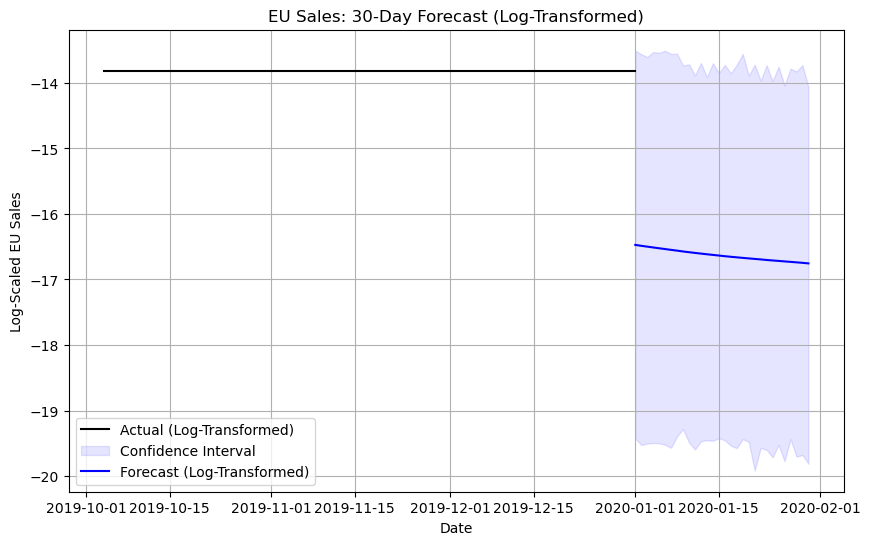

In [5]:
import pandas as pd
import numpy as np
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.fbprophet import Prophet
import matplotlib.pyplot as plt

# Load and prepare the dataset
sales_data = pd.read_csv("sales.csv")
sales_data['Year'] = pd.to_datetime(sales_data['Year'], format='%Y', errors='coerce')
sales_data = sales_data.dropna(subset=['Year', 'EU_Sales'])  # Remove rows with missing Year or EU_Sales

# Aggregate EU_Sales by year
sales_data = sales_data.groupby('Year')['EU_Sales'].sum()

# Apply log transformation and handle zeros
sales_data = sales_data.apply(lambda x: x if x > 0 else 1e-6)  # Replace zeros with small positive value
sales_data = sales_data.apply(np.log)  # Apply log transformation

# Resample to daily data and interpolate missing values
sales_data = sales_data.resample('D').interpolate(method='linear')  # Interpolate daily data

# Function to forecast using sktime
def sktime_forecast(dataset, horizon, forecaster, validation=False, confidence=0.9, frequency="D"):
    """Loop over a time series dataframe, train an sktime forecasting model, and visualize the results."""
    
    # Ensure the dataset is clean and resample as needed
    forecast_df = dataset.resample(rule=frequency).sum()
    forecast_df = forecast_df.interpolate(method="time")

    # Single-column dataset (for EU_Sales)
    df = forecast_df.dropna()

    if validation:
        y_train = df[:-horizon]
        y_test = df.tail(horizon)

        forecaster.fit(y_train)
        fh = ForecastingHorizon(y_test.index, is_relative=False)
        y_pred = forecaster.predict(fh)
        ci = forecaster.predict_interval(fh, coverage=confidence).astype("float")
        y_true = df.tail(horizon)
    else:
        forecaster.fit(df)

        last_date = df.index.max()
        fh = ForecastingHorizon(
            pd.date_range(str(last_date), periods=horizon, freq=frequency),
            is_relative=False,
        )

        y_pred = forecaster.predict(fh)
        ci = forecaster.predict_interval(fh, coverage=confidence).astype("float")

    # Visualize results
    plt.figure(figsize=(10, 6))
    plt.plot(df.tail(horizon * 3), label="Actual (Log-Transformed)", color="black")
    plt.fill_between(
        ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color="b", alpha=0.1, label="Confidence Interval"
    )
    plt.plot(y_pred, label="Forecast (Log-Transformed)", color="blue")
    plt.title("EU Sales: 30-Day Forecast (Log-Transformed)")
    plt.xlabel("Date")
    plt.ylabel("Log-Scaled EU Sales")
    plt.legend()
    plt.grid()
    plt.show()

# Forecast EU_Sales for the next 30 days
forecaster = Prophet(yearly_seasonality=True, weekly_seasonality=True)
sktime_forecast(dataset=sales_data, horizon=30, forecaster=forecaster, validation=False)


18:26:11 - cmdstanpy - INFO - Chain [1] start processing
18:26:20 - cmdstanpy - INFO - Chain [1] done processing


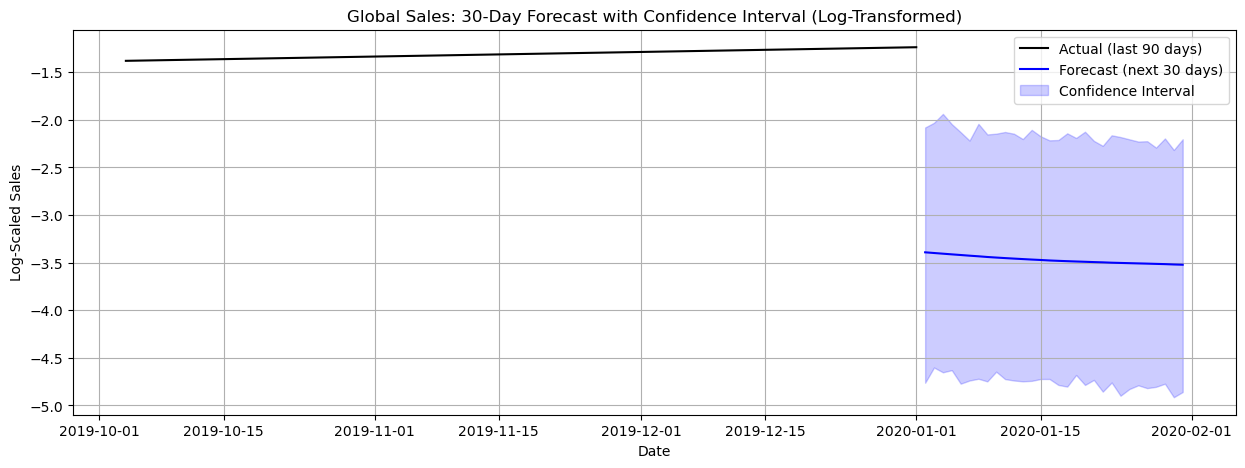

In [7]:
import pandas as pd
import numpy as np
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.fbprophet import Prophet
import matplotlib.pyplot as plt

# Load and prepare the data
sales_data = pd.read_csv("sales.csv")
sales_data['Year'] = sales_data['Year'].fillna(0).astype(int)
sales_data = sales_data[sales_data['Year'] > 0]
sales_data['Year'] = pd.to_datetime(sales_data['Year'], format='%Y')

# Aggregate global sales by year
sales_data = sales_data.groupby('Year')['Global_Sales'].sum()

# Apply a log transformation to handle small values
sales_data = sales_data.apply(lambda x: x if x > 0 else 1e-6)  # Avoid log(0) errors
sales_data = sales_data.apply(lambda x: np.log(x))  # Log transformation
sales_data = sales_data.resample('D').interpolate(method='linear')  # Interpolate daily data

# Forecasting function
def sktime_forecast_daily(dataset, horizon, forecaster, confidence=0.9):
    dataset = dataset.dropna()
    forecaster.fit(dataset)

    # Define forecast horizon
    last_date = dataset.index.max()
    fh = ForecastingHorizon(
        pd.date_range(last_date + pd.Timedelta(days=1), periods=horizon, freq='D'),
        is_relative=False,
    )

    # Generate predictions and confidence intervals
    y_pred = forecaster.predict(fh)
    ci = forecaster.predict_interval(fh, coverage=confidence)

    # Plot
    plt.figure(figsize=(15, 5))
    plt.plot(dataset[-90:], label="Actual (last 90 days)", color="black")
    plt.plot(y_pred, label="Forecast (next 30 days)", color="blue")
    plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color="blue", alpha=0.2, label="Confidence Interval")
    plt.title("Global Sales: 30-Day Forecast with Confidence Interval (Log-Transformed)")
    plt.xlabel("Date")
    plt.ylabel("Log-Scaled Sales")
    plt.legend()
    plt.grid()
    plt.show()

# Forecast for the next 30 days
forecaster = Prophet(yearly_seasonality=True, weekly_seasonality=True)
sktime_forecast_daily(dataset=sales_data, horizon=30, forecaster=forecaster, confidence=0.9)


18:26:21 - cmdstanpy - INFO - Chain [1] start processing
18:26:32 - cmdstanpy - INFO - Chain [1] done processing


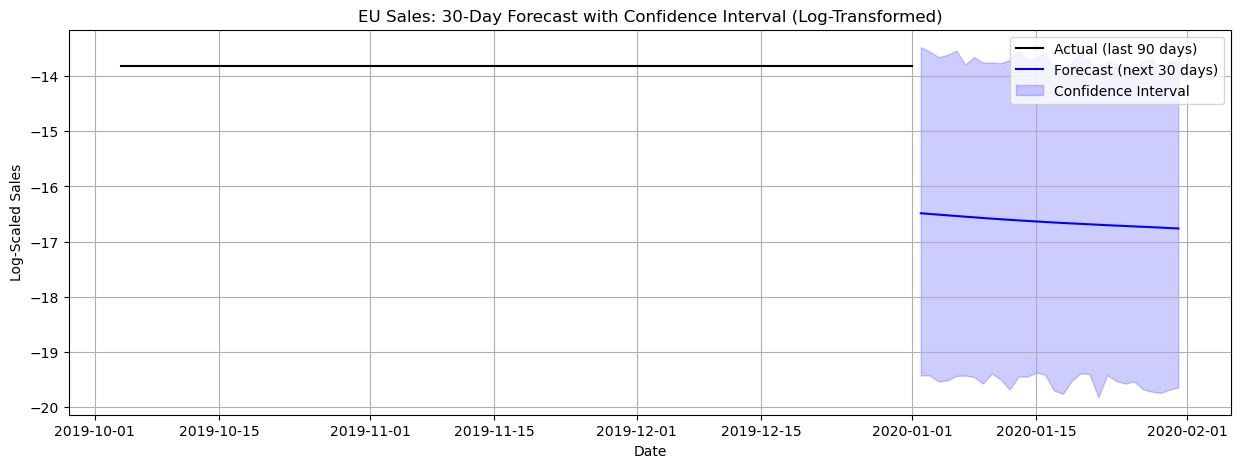

In [8]:
import pandas as pd
import numpy as np
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.fbprophet import Prophet
import matplotlib.pyplot as plt

# Load and prepare the data
sales_data = pd.read_csv("sales.csv")
sales_data['Year'] = sales_data['Year'].fillna(0).astype(int)
sales_data = sales_data[sales_data['Year'] > 0]
sales_data['Year'] = pd.to_datetime(sales_data['Year'], format='%Y')

# Aggregate global sales by year
sales_data = sales_data.groupby('Year')['EU_Sales'].sum()

# Apply a log transformation to handle small values
sales_data = sales_data.apply(lambda x: x if x > 0 else 1e-6)  # Avoid log(0) errors
sales_data = sales_data.apply(lambda x: np.log(x))  # Log transformation
sales_data = sales_data.resample('D').interpolate(method='linear')  # Interpolate daily data

# Forecasting function
def sktime_forecast_daily(dataset, horizon, forecaster, confidence=0.9):
    dataset = dataset.dropna()
    forecaster.fit(dataset)

    # Define forecast horizon
    last_date = dataset.index.max()
    fh = ForecastingHorizon(
        pd.date_range(last_date + pd.Timedelta(days=1), periods=horizon, freq='D'),
        is_relative=False,
    )

    # Generate predictions and confidence intervals
    y_pred = forecaster.predict(fh)
    ci = forecaster.predict_interval(fh, coverage=confidence)

    # Plot
    plt.figure(figsize=(15, 5))
    plt.plot(dataset[-90:], label="Actual (last 90 days)", color="black")
    plt.plot(y_pred, label="Forecast (next 30 days)", color="blue")
    plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color="blue", alpha=0.2, label="Confidence Interval")
    plt.title("EU Sales: 30-Day Forecast with Confidence Interval (Log-Transformed)")
    plt.xlabel("Date")
    plt.ylabel("Log-Scaled Sales")
    plt.legend()
    plt.grid()
    plt.show()

# Forecast for the next 30 days
forecaster = Prophet(yearly_seasonality=True, weekly_seasonality=True)
sktime_forecast_daily(dataset=sales_data, horizon=30, forecaster=forecaster, confidence=0.9)


18:26:34 - cmdstanpy - INFO - Chain [1] start processing
18:26:52 - cmdstanpy - INFO - Chain [1] done processing


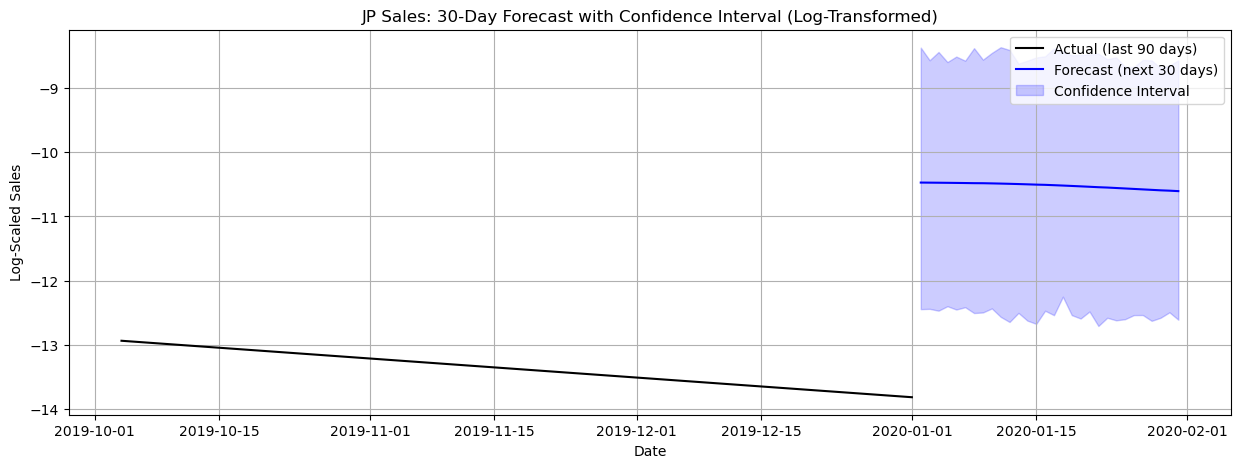

In [9]:
import pandas as pd
import numpy as np
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.fbprophet import Prophet
import matplotlib.pyplot as plt

# Load and prepare the data
sales_data = pd.read_csv("sales.csv")
sales_data['Year'] = sales_data['Year'].fillna(0).astype(int)
sales_data = sales_data[sales_data['Year'] > 0]
sales_data['Year'] = pd.to_datetime(sales_data['Year'], format='%Y')

# Aggregate global sales by year
sales_data = sales_data.groupby('Year')['JP_Sales'].sum()

# Apply a log transformation to handle small values
sales_data = sales_data.apply(lambda x: x if x > 0 else 1e-6)  # Avoid log(0) errors
sales_data = sales_data.apply(lambda x: np.log(x))  # Log transformation
sales_data = sales_data.resample('D').interpolate(method='linear')  # Interpolate daily data

# Forecasting function
def sktime_forecast_daily(dataset, horizon, forecaster, confidence=0.9):
    dataset = dataset.dropna()
    forecaster.fit(dataset)

    # Define forecast horizon
    last_date = dataset.index.max()
    fh = ForecastingHorizon(
        pd.date_range(last_date + pd.Timedelta(days=1), periods=horizon, freq='D'),
        is_relative=False,
    )

    # Generate predictions and confidence intervals
    y_pred = forecaster.predict(fh)
    ci = forecaster.predict_interval(fh, coverage=confidence)

    # Plot
    plt.figure(figsize=(15, 5))
    plt.plot(dataset[-90:], label="Actual (last 90 days)", color="black")
    plt.plot(y_pred, label="Forecast (next 30 days)", color="blue")
    plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color="blue", alpha=0.2, label="Confidence Interval")
    plt.title("JP Sales: 30-Day Forecast with Confidence Interval (Log-Transformed)")
    plt.xlabel("Date")
    plt.ylabel("Log-Scaled Sales")
    plt.legend()
    plt.grid()
    plt.show()

# Forecast for the next 30 days
forecaster = Prophet(yearly_seasonality=True, weekly_seasonality=True)
sktime_forecast_daily(dataset=sales_data, horizon=30, forecaster=forecaster, confidence=0.9)


In [13]:
import pandas as pd
import numpy as np
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.fbprophet import Prophet
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Function to prepare data
def prepare_data(file_path, sales_column):
    sales_data = pd.read_csv(file_path)
    sales_data['Year'] = sales_data['Year'].fillna(0).astype(int)
    sales_data = sales_data[sales_data['Year'] > 0]
    sales_data['Year'] = pd.to_datetime(sales_data['Year'], format='%Y')
    
    # Aggregate global sales by year
    sales_data = sales_data.groupby('Year')[sales_column].sum()
    
    # Apply log transformation and interpolate
    sales_data = sales_data.apply(lambda x: x if x > 0 else 1e-6)  # Avoid log(0) errors
    sales_data = sales_data.apply(lambda x: np.log(x))  # Log transformation
    sales_data = sales_data.resample('D').interpolate(method='linear')  # Interpolate daily data
    
    return sales_data

# Function to calculate and display MAE and RMSE
def calculate_mae_rmse(dataset, forecaster, horizon=30):
    train_data = dataset[:-horizon]  # All except the last 'horizon' days
    test_data = dataset[-horizon:]  # Last 'horizon' days
    last_date = train_data.index.max()
    
    # Fit the model
    forecaster.fit(train_data)
    
    # Define forecast horizon
    fh = ForecastingHorizon(
        pd.date_range(last_date + pd.Timedelta(days=1), periods=horizon, freq='D'),
        is_relative=False,
    )
    
    # Generate predictions
    y_pred = forecaster.predict(fh)
    
    # Calculate performance metrics
    mae = mean_absolute_error(test_data, y_pred)
    rmse = np.sqrt(mean_squared_error(test_data, y_pred))
    
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    
    return mae, rmse

# Load and prepare the data for EU Sales
file_path = "sales.csv"
sales_column = "EU_Sales"  # Change to "JP_Sales" for Japan sales
sales_data = prepare_data(file_path, sales_column)

# Initialize forecaster
forecaster = Prophet(yearly_seasonality=True, weekly_seasonality=True)

# Calculate MAE and RMSE
calculate_mae_rmse(sales_data, forecaster)


18:42:39 - cmdstanpy - INFO - Chain [1] start processing
18:42:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 2.56
Root Mean Squared Error (RMSE): 2.57


(2.5639981029561456, 2.565278820618379)